# HIV Modeling
By: Michael Remley

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# The Unconventional Method

This is the first way I got the model to work. It involves changing the parameters depending on how long the time step is and treating t_0 and t_end as counters for the number of steps.

Here's a make_system function to set up our initial state object, figure out our time step for interval t_step minutes, and adjust our parameters so they calculate right in the time steps. τ and ρ are the ones <strong> without </strong> a change to their value.

In [2]:
def make_system(params,t_0,t_end,t_step):
    """Make a system object for the RLEV model.
    
    params(Γ,μ,τ,β,ρ,α,σ,δ,π): see Table in paper
    t_0: Beginning time in days
    t_end: Ending time in days
    
    returns: System object
    Note: t_end is not in days
    """
    # Start with a number of active, uninfected cells and virons, but no infected cells of any kind
    init = State(R=200,L=0,E=0,V=4e-7)
    
    #Get our parameters
    Γ,μ,τ,β,ρ,α,σ,δ,π = params
    
    
    # Modify time-dependent parameters
    t_factor = 1440 / t_step
    t_end = t_end * t_factor
    
    return System(Γ=Γ/ t_factor,
                  μ=μ/ t_factor,
                  τ=τ,
                  β=β/ t_factor,
                  ρ=ρ, 
                  α=α/ t_factor, 
                  σ=σ/ t_factor, 
                  δ=δ/ t_factor, 
                  π=π/ t_factor, 
                  t_0=t_0, t_end=t_end,
                  t_step= 1/t_factor,init=init)

This is the update function that uses the differential equations described in the research paper as difference equations for a given time step. The first step is to calculate the flows and the second is to apply them to our stocks. It is important for these to be calculated then applied so each instance of r, l , e, and v is from the right row.

In [3]:
def update_func(state,t,system):
    """Update the RLEV model.
    
    state: State (R,L,E,V)
    t: time
    system: System object
    
    returns: State (sir)
    """
    r,l,e,v = state
    #Γ,μ,τ,β,ρ,α,σ,δ,π,t_0,t_end,init = system
    unpack(system)
    
    # Flow equations from the article
    ΔR = Γ*τ - μ*r - β*r*v
    ΔL = ρ*β*r*v - μ*l - α*l
    ΔE = (1.0 - ρ)*β*r*v + α*l - δ*e
    ΔV = π*e - σ*v
    
    # Calculate stock changes
    r += ΔR
    l += ΔL
    e += ΔE
    v += ΔV
    
    return State(R=r, L=l, E=e, V=v)

This is a standard run_simulation function except for the division of frame.index to give days.

In [4]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    frame = TimeFrame(columns=system.init.index)
    frame.row[t_0] = system.init
    
    for t in linrange(system.t_0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    frame.index *= t_step # Correct our index so it is in days
    return frame

In [28]:
def plot_results(results):
    # Calculate total CD4 Lymphocytes
    totalCD4s = TimeSeries()
    totalCD4s = 1000*(1-0.2)+results.R + results.L + results.E 
    
    # Calculate active CD4 lymphocytes, both healthy and infected flavors
    activecells = results.R + results.E + results.L

    # Make our figure and subplots
    f2, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize = (20,5),sharex=True)

    # Make subplot 1 with R, E, and L as a percentage of all CD4 cells (R, E, L, and inactives)
    ax1.plot(100*results.R/totalCD4s,label="Active healthy cells [R]")
    ax1.plot(100*results.E/totalCD4s,label="Actively infected cells [E]")
    ax1.plot(100*results.L/totalCD4s,"--",label="Latently infected cells [L]")
    ax1.set_ylabel("Percentage of CD4 Lymphocytes")
    ax1.legend()
    ax1.grid()

    # Make subplot 2 with the free virons
    ax2.plot(results.V,label="Free Virons [V]")
    ax2.set_ylabel("Virons [V]")
    ax2.grid()

    # Make subplot 3 with Total CD4 cells
    ax3.plot(totalCD4s,label="Total CD4 Lymphocytes")
    ax3.set_ylabel("Total CD4 Lymphocytes")
    ax3.grid()

With the functions squared away, we can get our parameters, make a system, and run the simulation. The units in the original article are not very descriptive, so I added a little more detail here.

In [6]:
params = Params(Γ = 1.36,    # [CD4-cells / day],     new CD4 cells per day, both active and inactive
                μ = 1.36e-3, # [1 / day],             standard death rate, HIV independent, per day
                τ = 0.2,     # [R-cells / CD4-cells], active cells from total CD4 cells
                β = 0.00027, # [1 / (Virons*day)],    infection of active, healthy cells in one day
                ρ = 0.1,     # [L-cells / R-cells],   L-cells that become actively infected per R-cells
                α = 3.6e-2,  # [Cells / L-cells],     rate of infected cells becoming active
                σ = 2,       # [1 / (Virons * day)],  death rate of Virons in one day
                δ = 1/3,     # [1 / day],             death rate of E in one day
                π = 100      # [Virons / (E-cells * day)], new virons produced by E-cells in one day
               )
# Make a system to run for 120 days with 1 day (1440 minute) time steps
system = make_system(params,0,120,80)
%time results = run_simulation(system, update_func)

Wall time: 6.77 s


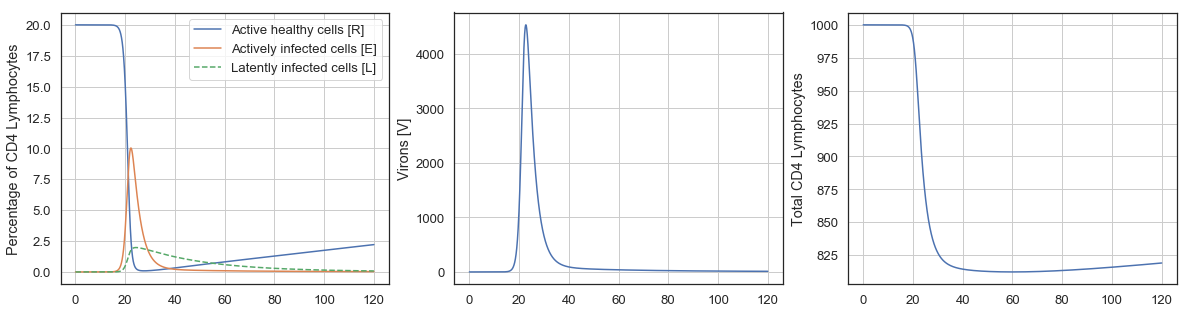

In [29]:
plot_results(results)

# Euler's Method

This is an adaptation of the method we were <strong>supposed</strong> to use. We need a new make_system, update_func, and run_simulation.

In [8]:
def make_system2(params,t_0,t_end,dt):
    """Make a system object for the RLEV model.
    
    params(Γ,μ,τ,β,ρ,α,σ,δ,π): see Table in paper
    t_0: Beginning time in days
    t_end: Ending time in days
    dt: time step in days
    
    returns: System object
    """
    # Start with a number of active, uninfected cells and virons, but no infected cells of any kind
    init = State(R=200,L=0,E=0,V=4e-7)
    
    #Get our parameters
    Γ,μ,τ,β,ρ,α,σ,δ,π = params    

    return System(Γ=Γ, μ=μ, τ=τ,
                  β=β, ρ=ρ, α=α, 
                  σ=σ, δ=δ, π=π, 
                  t_0=t_0, t_end=t_end, dt=dt, init=init)

In [9]:
def update_func2(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    r,l,e,v = state
    unpack(system)
    
    # Flow equations from the article
    dRdt = Γ*τ - μ*r - β*r*v
    dLdt = ρ*β*r*v - μ*l - α*l
    dEdt = (1.0 - ρ)*β*r*v + α*l - δ*e
    dVdt = π*e - σ*v
    
    # Calculate stock changes
    r += dRdt * dt
    l += dLdt * dt
    e += dEdt * dt
    v += dVdt * dt
    
    return State(R=r, L=l, E=e, V=v)

In [10]:
def run_simulation2(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [11]:
params = Params(Γ = 1.36,    # [CD4-cells / day],     new CD4 cells per day, both active and inactive
                μ = 1.36e-3, # [1 / day],             standard death rate, HIV independent, per day
                τ = 0.2,     # [R-cells / CD4-cells], active cells from total CD4 cells
                β = 0.00027, # [1 / (Virons*day)],    infection of active, healthy cells in one day
                ρ = 0.1,     # [L-cells / R-cells],   L-cells that become actively infected per R-cells
                α = 3.6e-2,  # [Cells / L-cells],     rate of infected cells becoming active
                σ = 2,       # [1 / (Virons * day)],  death rate of Virons in one day
                δ = 0.33,     # [1 / day],             death rate of E in one day
                π = 100      # [Virons / (E-cells * day)], new virons produced by E-cells in one day
               )
# Make a system to run for 120 days with 80 minute time steps
system2 = make_system2(params,0,120,1/18)
%time results2 = run_simulation2(system2, update_func2)

Wall time: 7.15 s


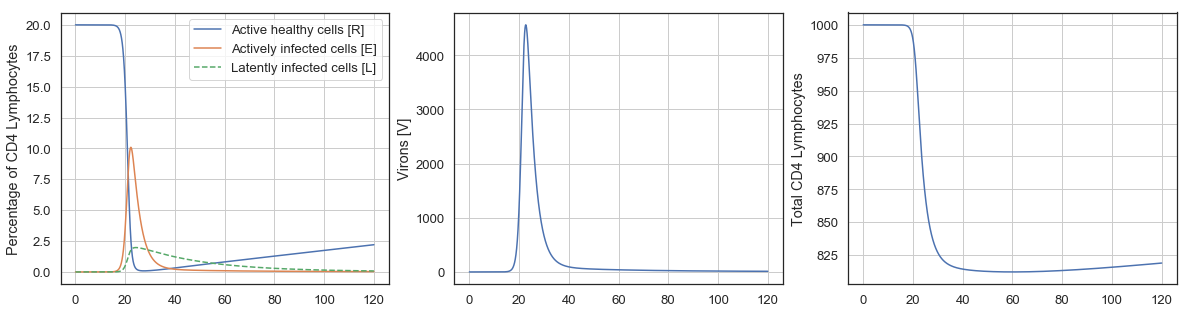

In [31]:
plot_results(results2)

# The ODE Solver Method

This one is my personal favorite.

In [13]:
def slope_func(state,t,system):
    """Update the RLEV model.
    
    state: State (R,L,E,V)
    t: time
    system: System object
    
    returns: State (sir)
    """
    r,l,e,v = state
    unpack(system)
    
    # Flow equations from the article
    dRdt = Γ*τ - μ*r - β*r*v
    dLdt = ρ*β*r*v - μ*l - α*l
    dEdt = (1.0 - ρ)*β*r*v + α*l - δ*e
    dVdt = π*e - σ*v
    
    return dRdt, dLdt, dEdt, dVdt

In [14]:
# Make a system to run for 120 days
system3 = make_system2(params,0,120,1) # dt is passed as 1, although run_ode_solver does not use it
%time results3, details = run_ode_solver(system3, slope_func);

Wall time: 193 ms


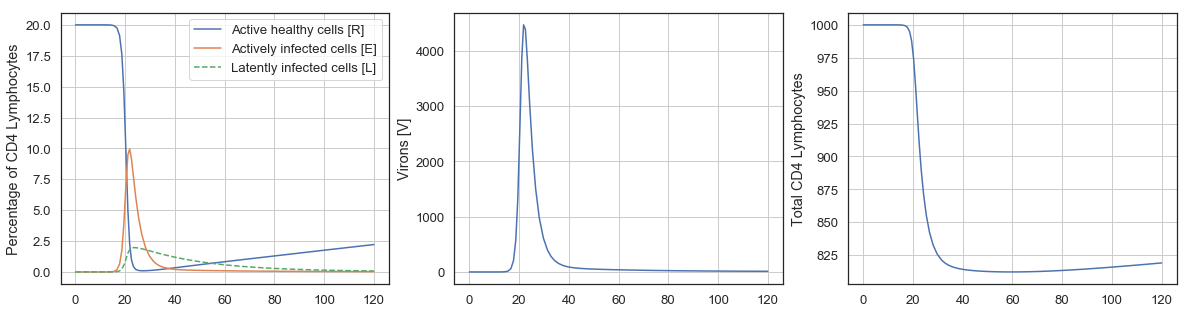

In [30]:
plot_results(results3)